# 1 + 1 = 1 or Record Deduplication with Python

## Introduction

Real world data is inputted by people and usually not reviewed nor normalized, so it often:
  * lacks unique identifiers (making difficult detect duplicates in a dataset or to link with other datasets)
  * duplicated (e.g. multiple records refer to a single person)
  * inconsistent (e.g. a person appears with multiple addresses)
  * not properly formatted (e.g. birth dates appear with multiple formats like DD/MM/YY and YYYY-MM-DD)

All of that affects the ability to properly **extract knowledge** from one or more datasets.

The solution is to perform **[Record Linkage](https://en.wikipedia.org/wiki/Record_linkage)**. It works by joining records with **fuzzy data** like names, addresses, dates, etc.

The term Record Linkage is most used when the linkage is applied to multiple datasets, like joining Restaurant wage data with Food Inspections data. In fact, [someone did just that](https://www.enigma.com/blog/on-wages-and-hygiene-surfacing-bad-management-in-public-data).

What we'll discuss here is a specific application of Record Linkage, called **Deduplication**, which is most used when the linkage is applied to a single dataset to **find which records are duplicates**.

In [1]:
import pandas as pd

data = [
    ("Chin's","3200 Las Vegas Boulevard","New York"),
    ("Chin Bistro","3200 Las Vegas Blvd.","New York"),
    ("Bistro","3400 Las Vegas Blvd.","New York City"),
    ("Bistro","3400 Las Vegas B.","NYC"),
]

pd.DataFrame(data, columns=['restaurant', 'address', 'city'])

/Users/fjsj/workspace/deduplication-slides/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/fjsj/workspace/deduplication-slides/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


,restaurant,address,city
0,Chin's,3200 Las Vegas Boulevard,New York
1,Chin Bistro,3200 Las Vegas Blvd.,New York
2,Bistro,3400 Las Vegas Blvd.,New York City
3,Bistro,3400 Las Vegas B.,NYC


A good deduplication on the data above would find that:
  - `(0, 1)` are duplicates
  - `(2, 3)` are duplicates 
  - but sets `(0, 1)` and `(2, 3)` are different

## Process

The process for deduplicating a dataset usually is:
  0. Preprocessing
    * input: dataset 
    * output: cleaned dataset
  1. Indexing
    * output: pairs to compare
  2. Comparison
    * output: comparison vectors
  3. Classification
    * output: matching/nonmatching pairs
  4. Clustering 
    * output: unique record clusters
    
Let's explore each of those steps!

## 0/4 - Preprocessing

Without unique identifiers, we usually have to **clean** the following types of data:
- Names
- Addresses
- Phone Numbers
- Dates


### Cleaning names (companies or people)

Let's use regexes to **normalize** names and remove undesired variations:

In [2]:
import numpy as np
import re
import pprint

print("Before cleaning:")
company_names = [
    'APPLE COMPUTER INC',
    'APPLE COMPUTER, INC.',
    'APPLE INC',
    'Apple Computer',
    'Apple Computer Co.',
    'Apple Computer Company',
    'Apple Computer Inc',
    'Apple Computer Incorporated',
    'Apple Computer, Inc.',
    'Apple Inc',
    'Apple Inc.',
    'Apple, Inc.'
]
pprint.pprint(company_names)

Before cleaning:
['APPLE COMPUTER INC',
 'APPLE COMPUTER, INC.',
 'APPLE INC',
 'Apple Computer',
 'Apple Computer Co.',
 'Apple Computer Company',
 'Apple Computer Inc',
 'Apple Computer Incorporated',
 'Apple Computer, Inc.',
 'Apple Inc',
 'Apple Inc.',
 'Apple, Inc.']


In [3]:
print("Lower case:")
company_names = [c.lower() for c in company_names]
pprint.pprint(company_names)

Lower case:
['apple computer inc',
 'apple computer, inc.',
 'apple inc',
 'apple computer',
 'apple computer co.',
 'apple computer company',
 'apple computer inc',
 'apple computer incorporated',
 'apple computer, inc.',
 'apple inc',
 'apple inc.',
 'apple, inc.']


In [4]:
print("Remove irrelevant separators:")
irrelevant_regex = re.compile(r'[^a-z0-9\s]')
company_names = [irrelevant_regex.sub(' ', c) for c in company_names]
pprint.pprint(company_names)

Remove irrelevant separators:
['apple computer inc',
 'apple computer  inc ',
 'apple inc',
 'apple computer',
 'apple computer co ',
 'apple computer company',
 'apple computer inc',
 'apple computer incorporated',
 'apple computer  inc ',
 'apple inc',
 'apple inc ',
 'apple  inc ']


In [5]:
print("Remove multi-spaces:")
multispace_regex = re.compile(r'\s\s+')
company_names = [multispace_regex.sub(' ', c).strip() for c in company_names]
pprint.pprint(company_names)

Remove multi-spaces:
['apple computer inc',
 'apple computer inc',
 'apple inc',
 'apple computer',
 'apple computer co',
 'apple computer company',
 'apple computer inc',
 'apple computer incorporated',
 'apple computer inc',
 'apple inc',
 'apple inc',
 'apple inc']


In [6]:
print("Remove stopwords:")
business_stopwords = {
    'computer',
    'computers',
    'co',
    'corp',
    'corporate',
    'corporation',
    'company',
    'electronic',
    'electronics',
    'inc',
    'incorporated',
    'limited',
    'llc',
    #...
}

company_names = [
    ' '.join([c_part for c_part in c.split() if c_part not in company_names])
    for c in company_names
]
pprint.pprint(company_names)

Remove stopwords:
['apple computer inc',
 'apple computer inc',
 'apple inc',
 'apple computer',
 'apple computer co',
 'apple computer company',
 'apple computer inc',
 'apple computer incorporated',
 'apple computer inc',
 'apple inc',
 'apple inc',
 'apple inc']


We can also use the NLP library [**probablepeople**](https://github.com/datamade/probablepeople) to **parse company names** and extract just the part we want (or break into parts and match by part on the comparison step later):

In [7]:
import probablepeople as pp

pp.parse("Apple Computer Incorporated")

[('Apple', 'CorporationName'),
 ('Computer', 'CorporationName'),
 ('Incorporated', 'CorporationLegalType')]

In [8]:
company_names_alternative_1 = [
    [
        parsed_value
        for parsed_value, parsed_type
        in pp.parse(c)
        if parsed_type == 'CorporationName'
    ]
    for c in company_names
]
pprint.pprint(company_names_alternative_1)

[['apple', 'computer'],
 ['apple', 'computer'],
 ['apple'],
 ['apple', 'computer'],
 ['apple', 'computer'],
 ['apple', 'computer'],
 ['apple', 'computer'],
 ['apple', 'computer'],
 ['apple', 'computer'],
 ['apple'],
 ['apple'],
 ['apple']]


There's also a (unmaintained) library that does something similar called [**cleanco**](https://github.com/psolin/cleanco).

probablepeople, as the name suggests, can parse **people** names too:

In [9]:
pp.parse('Mr. Guido van Rossum')

[('Mr.', 'PrefixMarital'),
 ('Guido', 'GivenName'),
 ('van', 'Surname'),
 ('Rossum', 'Surname')]

But performance isn't great from non-English names. So you can try [**nameparser**](https://github.com/derek73/python-nameparser/), which is **not probabilistic**:

In [10]:
from nameparser import HumanName
from IPython.display import display

display(pp.parse('Flávio Juvenal da Silva Jr'))
display(HumanName('Flávio Juvenal da Silva Jr'))

[('Flávio', 'CorporationName'),
 ('Juvenal', 'CorporationName'),
 ('da', 'CorporationName'),
 ('Silva', 'CorporationName'),
 ('Jr', 'CorporationName')]

<HumanName : [
	title: '' 
	first: 'Flávio' 
	middle: 'Juvenal' 
	last: 'da Silva' 
	suffix: 'Jr'
	nickname: ''
]>

If it's useful to **ignore accents**, try [**unidecode**](https://github.com/avian2/unidecode):

In [11]:
import unidecode

print("ASCII transliteration:")
brazilian_name = "Flávio"
print(brazilian_name, "->")
print(unidecode.unidecode(brazilian_name))

ASCII transliteration:
Flávio ->
Flavio


It's important to consider how the data values were inputted. If the value was typed by someone while hearing from someone else, try **phonetic encoding** with [doublemetaphone](https://github.com/dedupeio/doublemetaphone) to normalize it:

In [12]:
from doublemetaphone import doublemetaphone

print(doublemetaphone('Andrew'))
print(doublemetaphone('André'))

('ANTR', 'ANTRF')
('ANTR', 'ANTR')


If data was obtained via Optical Character Recognition (OCR), techniques exist to correct common misspellings that OCRs make (like C to L, S to 5, q to g, etc). See Christen page 47.

### Cleaning addresses

Geocoding street addresses, i.e., converting them to **latitude/longitude** is very useful for matching, because geocoders usually clean irrelevant addresses variations. Also, having lat/lng enables the calculation of geometric distances between addresses.

In [13]:
import requests
import geocoder

full_addresses = [
    "2066 Crist Drive",
    "2066 Crist Dr",
    "20863 Stevens Creek Blvd., Suite 300",
    "20863 STEVENS CREEK BLVD STE 330",
    "10260 Bandley Drive",
    "10260 Bandley Dr.",
    "20525 MARIANI AVENUE",
    "20525 Mariani Ave",
    "1 Infinite Loop",
    "One Infinite Loop,",
    "One Apple Park Way",
    "1 Apple Park Way",
]
pprint.pprint(list(full_addresses))
print()

full_addresses_latlng = []
with requests.Session() as session:
    for a in full_addresses:
        a_geocoded = geocoder.google(a, session=session)
        full_addresses_latlng.append(a_geocoded.latlng)
pprint.pprint(list(zip(full_addresses, full_addresses_latlng)))

['2066 Crist Drive',
 '2066 Crist Dr',
 '20863 Stevens Creek Blvd., Suite 300',
 '20863 STEVENS CREEK BLVD STE 330',
 '10260 Bandley Drive',
 '10260 Bandley Dr.',
 '20525 MARIANI AVENUE',
 '20525 Mariani Ave',
 '1 Infinite Loop',
 'One Infinite Loop,',
 'One Apple Park Way',
 '1 Apple Park Way']

[('2066 Crist Drive', [37.3403342, -122.068897]),
 ('2066 Crist Dr', [37.3403342, -122.068897]),
 ('20863 Stevens Creek Blvd., Suite 300', [37.3241563, -122.0387297]),
 ('20863 STEVENS CREEK BLVD STE 330', [37.3241563, -122.0387297]),
 ('10260 Bandley Drive', [37.3283271, -122.033743]),
 ('10260 Bandley Dr.', [37.3283271, -122.033743]),
 ('20525 MARIANI AVENUE', [37.330827, -122.033482]),
 ('20525 Mariani Ave', [37.330827, -122.033482]),
 ('1 Infinite Loop', [37.3324975, -122.0289785]),
 ('One Infinite Loop,', [37.33182, -122.03118]),
 ('One Apple Park Way', [38.9058776, -94.38134679999999]),
 ('1 Apple Park Way', [37.3346326, -122.0126824])]


Google geocoder is able to:
- Ignore lower/upper case difference
- Expand abbreviations, like 'Avenue' vs 'Ave'
- Consider 'Lupertino' as 'Cupertino'

As a geocoder, it also ignores the difference between Suite 300 and STE 330, since probably the building entrance is the same.  
However, it gets slighly different addresses on the case of '1' vs 'One' on the last 4 cases.

Note geocoding from web APIs is slow and has quota limits! Alternatively, you can build **your own geocoder** with:
- https://github.com/openstreetmap/Nominatim
- https://github.com/pelias/pelias
- https://github.com/komoot/photon
- https://postgis.net/docs/Extras.html
- https://github.com/openvenues/lieu

If geocoding is inviable, we can use the library [pypostal](https://github.com/openvenues/pypostal) to **normalize** addresses:

In [14]:
from postal.expand import expand_address

print(full_addresses[8])
pprint.pprint(expand_address(full_addresses[8]))
print()

print(full_addresses[9])
pprint.pprint(expand_address(full_addresses[9]))

1 Infinite Loop
['1 infinite loop']

One Infinite Loop,
['1 infinite loop']


In [15]:
print(full_addresses[2])
pprint.pprint(expand_address(full_addresses[2]))
print()

print(full_addresses[3])
pprint.pprint(expand_address(full_addresses[3]))

20863 Stevens Creek Blvd., Suite 300
['20863 stevens creek boulevard suite 300']

20863 STEVENS CREEK BLVD STE 330
['20863 stevens creek boulevard suite 330',
 '20863 stevens creek boulevard sainte 330']


From the creators of nameparsers, there's a [usaddress](https://github.com/datamade/usaddress) **parser**:

In [16]:
import usaddress

print(full_addresses[0])
pprint.pprint(usaddress.parse(full_addresses[0]))
print()

print(full_addresses[1])
pprint.pprint(usaddress.parse(full_addresses[1]))
print()

2066 Crist Drive
[('2066', 'AddressNumber'),
 ('Crist', 'StreetName'),
 ('Drive', 'StreetNamePostType')]

2066 Crist Dr
[('2066', 'AddressNumber'),
 ('Crist', 'StreetName'),
 ('Dr', 'StreetNamePostType')]



### Cleaning phone numbers

[phonenumbers](https://github.com/daviddrysdale/python-phonenumbers) library can **normalize** phone numbers from many countries:

In [17]:
import phonenumbers

print("Phone number normalization:")
phone = "(541) 555-3010"
print(phone, '->')
print(
    phonenumbers.format_number(
        phonenumbers.parse(phone, 'US'),
        phonenumbers.PhoneNumberFormat.E164)
)

Phone number normalization:
(541) 555-3010 ->
+15415553010


### Cleaning dates

[dateparser](https://github.com/scrapinghub/dateparser) library can **guess** date formats and parse them as datetime objects. It can even guess DD/MM or MM/DD by the language:

In [18]:
import dateparser

print(dateparser.parse("at 10/1/2018 10am"))
print(dateparser.parse("às 10/1/2018 10:00"))
pprint.pprint(dateparser.DateDataParser().get_date_data("às 10/1/2018 10:00"))

2018-10-01 10:00:00
2018-01-10 10:00:00
{'date_obj': datetime.datetime(2018, 1, 10, 10, 0),
 'locale': 'pt',
 'period': 'day'}


Check also [dateutil parser](https://dateutil.readthedocs.io/en/stable/parser.html#dateutil.parser.parse) with `fuzzy=True`.

### Cleaning a real dataset

Now we know the tools, let's **grab a dataset to preprocess and go on the other deduplication steps**. Our dataset is based* on the academic [Restaurant](https://www.cs.utexas.edu/users/ml/riddle/data.html) dataset. It contains 881 restaurant records and contains 150 duplicates.

\* We've introduced some changes that you can check by doing a `diff restaurant.original.csv restaurant.csv`

In [19]:
df_with_truth = pd.read_csv('restaurant.csv', skip_blank_lines=True)
df_with_truth.head(9)

,name,addr,city,phone,type,cluster
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles,310/246-1501,american,0
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,310-246-1501,steakhouses,0
2,arnie morton,435 s. la cienega boulevard,los angeles,310-246-1501,steakhouses,0
3,art's delicatessen,12224 ventura blvd.,studio city,818/762-1221,american,1
4,art's deli,12224 ventura blvd.,studio city,818-762-1221,delis,1
5,art's deli,12224 ventura blvd.,los angeles,818-762-1221,delis,1
6,hotel bel-air,701 stone canyon rd.,bel air,310/472-1211,californian,2
7,bel-air hotel,701 stone canyon rd.,bel air,310-472-1211,californian,2
8,bel-air,701 stone canyon road,bel air,(310) 472-1211,american,2


The dataset comes with the true matches indicated by the `cluster` column. We'll remove it. We'll also remove the phone to makes things more difficult:

In [20]:
df = df_with_truth.drop(columns=['cluster', 'phone'])
df.head(9)

,name,addr,city,type
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles,american
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,steakhouses
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses
3,art's delicatessen,12224 ventura blvd.,studio city,american
4,art's deli,12224 ventura blvd.,studio city,delis
5,art's deli,12224 ventura blvd.,los angeles,delis
6,hotel bel-air,701 stone canyon rd.,bel air,californian
7,bel-air hotel,701 stone canyon rd.,bel air,californian
8,bel-air,701 stone canyon road,bel air,american


Now we'll clean the column values! Cleaning the **name**:

In [21]:
def assign_no_symbols_name(df):
    return df.assign(
        name=df['name'].astype(str)
             .str.replace(irrelevant_regex, ' ')
             .str.replace(multispace_regex, ' '))

df = assign_no_symbols_name(df)
df.head(9)

,name,addr,city,type
0,arnie morton s of chicago,435 s. la cienega blv.,los angeles,american
1,arnie morton s of chicago,435 s. la cienega blvd.,los angeles,steakhouses
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses
3,art s delicatessen,12224 ventura blvd.,studio city,american
4,art s deli,12224 ventura blvd.,studio city,delis
5,art s deli,12224 ventura blvd.,los angeles,delis
6,hotel bel air,701 stone canyon rd.,bel air,californian
7,bel air hotel,701 stone canyon rd.,bel air,californian
8,bel air,701 stone canyon road,bel air,american


In [22]:
from collections import Counter

possible_stopwords = Counter(" ".join(df["name"]).split()).most_common(20)
pprint.pprint(possible_stopwords)

[('s', 184),
 ('cafe', 81),
 ('the', 39),
 ('grill', 32),
 ('restaurant', 26),
 ('la', 24),
 ('le', 20),
 ('house', 20),
 ('bar', 19),
 ('of', 15),
 ('bistro', 13),
 ('room', 11),
 ('kitchen', 10),
 ('deli', 9),
 ('club', 9),
 ('and', 9),
 ('ritz', 9),
 ('carlton', 9),
 ('on', 8),
 ('buckhead', 8)]


In [23]:
def assign_cleaned_name(df):
    restaurant_stopwords = {
        's',
        'the',
        'la',
        'le',
        'of',
        'and',
        'on',
        'l',
    }
    restaurant_stopwords_regex = r'\b(?:{})\b'.format(
        '|'.join(restaurant_stopwords))
    return df.assign(
        name=df['name'].astype(str)
                       .str.replace(restaurant_stopwords_regex, '')
                       .str.replace(multispace_regex, ' ')
                       .str.strip())

df = assign_cleaned_name(df)
df.head(9)

,name,addr,city,type
0,arnie morton chicago,435 s. la cienega blv.,los angeles,american
1,arnie morton chicago,435 s. la cienega blvd.,los angeles,steakhouses
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses
3,art delicatessen,12224 ventura blvd.,studio city,american
4,art deli,12224 ventura blvd.,studio city,delis
5,art deli,12224 ventura blvd.,los angeles,delis
6,hotel bel air,701 stone canyon rd.,bel air,californian
7,bel air hotel,701 stone canyon rd.,bel air,californian
8,bel air,701 stone canyon road,bel air,american


Cleaning the **addr**:

In [24]:
all_addresses = df['addr'].astype(str).str.cat(
    df['city'].astype(str), sep=', ').values
unique_addresses = np.unique(all_addresses)
print(len(all_addresses), len(unique_addresses))

881 819


In [25]:
import os.path
import json

geocoding_filename = 'address_to_geocoding.json'

def geocode_addresses(address_to_geocoding):
    remaining_addresses = set(unique_addresses) - set(address_to_geocoding.keys())
    
    with requests.Session() as session:
        for i, address in enumerate(remaining_addresses):
            print(f"Geocoding {i + 1}/{len(remaining_addresses)}")
            geocode_result = geocoder.google(address, session=session)
            address_to_geocoding[address] = geocode_result.json

        with open(geocoding_filename, 'w') as f:
            json.dump(address_to_geocoding, f, indent=4)

if not os.path.exists(geocoding_filename):
    address_to_geocoding = {}
    geocode_addresses(address_to_geocoding)
else:
    with open(geocoding_filename) as f:
        address_to_geocoding = json.load(f)
    geocode_addresses(address_to_geocoding)
 
address_to_postal = {
    k: v['postal']
    for k, v in address_to_geocoding.items()
    if v is not None and 'postal' in v
}
address_to_latlng = {
    k: (v['lat'], v['lng'])
    for k, v in address_to_geocoding.items()
    if v is not None
}
print(f"Failed to get postal from {len(address_to_geocoding) - len(address_to_postal)}")
print(f"Failed to get latlng from {len(address_to_geocoding) - len(address_to_latlng)}")

Failed to get postal from 16
Failed to get latlng from 8


In [26]:
def assign_postal_lat_lng(df):
    addresses = df['addr'].astype(str).str.cat(df['city'].astype(str), sep=', ')
    addresses_to_postal = [address_to_postal.get(a) for a in addresses]
    addresses_to_lat = [address_to_latlng[a][0] if a in address_to_latlng else None for a in addresses]
    addresses_to_lng = [address_to_latlng[a][1] if a in address_to_latlng else None for a in addresses]

    return df.assign(postal=addresses_to_postal, lat=addresses_to_lat, lng=addresses_to_lng)

df = assign_postal_lat_lng(df)
df.head(9)

,name,addr,city,type,postal,lat,lng
0,arnie morton chicago,435 s. la cienega blv.,los angeles,american,90048,34.070609,-118.376722
1,arnie morton chicago,435 s. la cienega blvd.,los angeles,steakhouses,90048,34.070609,-118.376722
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses,90048,34.070609,-118.376722
3,art delicatessen,12224 ventura blvd.,studio city,american,91604,34.142966,-118.399469
4,art deli,12224 ventura blvd.,studio city,delis,91604,34.142966,-118.399469
5,art deli,12224 ventura blvd.,los angeles,delis,91604,34.142966,-118.399469
6,hotel bel air,701 stone canyon rd.,bel air,californian,90077,34.086594,-118.446351
7,bel air hotel,701 stone canyon rd.,bel air,californian,90077,34.086594,-118.446351
8,bel air,701 stone canyon road,bel air,american,90077,34.086594,-118.446351


In [27]:
def assign_addr_variations(df):
    return df.assign(
        addr_variations=df['addr'].astype(str).apply(
            lambda addr: frozenset(expand_address(addr))))

df = assign_addr_variations(df)
df.head(9)

,name,addr,city,type,postal,lat,lng,addr_variations
0,arnie morton chicago,435 s. la cienega blv.,los angeles,american,90048,34.070609,-118.376722,"(435 san lane cienega boulevard, 435 san lane ..."
1,arnie morton chicago,435 s. la cienega blvd.,los angeles,steakhouses,90048,34.070609,-118.376722,"(435 sur lane cienega boulevard, 435 san la ci..."
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses,90048,34.070609,-118.376722,"(435 san la cienega boulevard, 435 san lane ci..."
3,art delicatessen,12224 ventura blvd.,studio city,american,91604,34.142966,-118.399469,(12224 ventura boulevard)
4,art deli,12224 ventura blvd.,studio city,delis,91604,34.142966,-118.399469,(12224 ventura boulevard)
5,art deli,12224 ventura blvd.,los angeles,delis,91604,34.142966,-118.399469,(12224 ventura boulevard)
6,hotel bel air,701 stone canyon rd.,bel air,californian,90077,34.086594,-118.446351,(701 stone canyon road)
7,bel air hotel,701 stone canyon rd.,bel air,californian,90077,34.086594,-118.446351,(701 stone canyon road)
8,bel air,701 stone canyon road,bel air,american,90077,34.086594,-118.446351,(701 stone canyon road)


## Indexing

To explain the following deduplication steps, we'll use the Python libary recordlinkage, aka **[Python Record Linkage Toolkit](http://recordlinkage.readthedocs.io/en/latest/ref-compare.html)**. It's the best library for learning about deduplication because it doesn't abstract too much the details of the process, even though it has a simple API.

We have the cleaned records, we now need the pairs we want to compare to find matches.
To **produce the pairs**, we could do a "full" index, i.e., all records against all records.

In [28]:
import recordlinkage as rl

full_indexer = rl.FullIndex()
pairs = full_indexer.index(df)

print(f"Full index: {len(df)} records, {len(pairs)} pairs")

Full index: 881 records, 387640 pairs


The formula for the total number of pairs: `len(df) * (len(df) - 1) / 2 == 385881`

The number of pairs grows too fast as the number of records grows. It grows quadratically.
That's why we need **indexing**. We need to produce only pairs that already have something in common, that are good candidates for being duplicates.

Indexing is also called **blocking** because the straightforward way to index is to produce pairs that have **some column value in common**. By doing this, you produce blocks of record pairs and compare only those in the same block:

TODO standard-blocking.png

In [29]:
postal_indexer = rl.BlockIndex('postal')
postal_index_pairs = postal_indexer.index(df)

print(f"Postal index: {len(postal_index_pairs)} pairs")

Postal index: 6402 pairs


We could also prouce pairs by sorting the unique values of some column and, for each value, getting the records with **neighboring values**. The idea is to produce pairs with close values on some column, like `johnny` and `john` or  `2018-01-02` and `2018-01-05`. However, simply sorting values wouldn't be able to get `kamila` and `camila` as neighbors, as sorting is sensitive to the leading characters of strings.

TODO: sorted-neighbourhood.png

In [30]:
name_indexer = rl.SortedNeighbourhoodIndex('name', window=7)
name_index_pairs = name_indexer.index(df)

print(f"Name index: {len(name_index_pairs)} pairs")

Name index: 3132 pairs


It's worth noting that indexing can contribute with **accuracy** too, as there's no guarantee we'll give the same priority on the comparision step to the columns we used in blocking.

To produce more pairs without introducing redundant pairs, we should **union** different indexes:

In [31]:
pairs = postal_index_pairs.union(name_index_pairs)

print(f"Postal or name index: {len(pairs)} pairs")

Postal or name index: 9336 pairs


We now have **which pairs** we want to run comparisons on!

## Comparison

Now we want to **run comparisons** on the indexed pairs to produce a comparison vector for each pair. A comparison vector represents the similarity between 2 records by holding similarity values between 0 to 1 for each column in records.

In [32]:
pd.DataFrame([[1.0, 0.75, 0.0, 0.25]],
             columns=['name', 'addr', 'type', 'latlng'],
             index=pd.MultiIndex.from_arrays([[100], [200]]))

,,name,addr,type,latlng
100,200,1.0,0.75,0.0,0.25


For example, the comparison vector above means the pair of records `(100, 200)` has:
- Equal `name`s
- Similar `addr`s
- Completely different `type`s
- Some distance on `latlng`s

To compute the comparison vectors for all indexed pairs, we define a **comparison function** for each column:

In [33]:
vectorized_intersection = np.vectorize(
    lambda x, y: float(bool(x.intersection(y))))

def compare_addr_variations(a1, a2):
    return vectorized_intersection(a1, a2)

comp = rl.Compare()
comp.string('name', 'name',
            method='jarowinkler',
            label='name')
comp.string('addr', 'addr',
            method='lcs',
            label='addr')
comp.string('type', 'type',
            method='jarowinkler',
            label='type')
comp.geo('lat', 'lng', 'lat', 'lng', 
         method='exp', scale=0.5,
         label='latlng')
comp.compare_vectorized(compare_addr_variations,
                        'addr_variations', 'addr_variations',
                        label='addr_variations')

<Compare>

There are many **similarity functions** we could use for strings. For example:
- `jarowinkler` gives priority to the begining of the string
- `levenshtein` cares more about the order
- `lcs` cares less about the order

In [34]:
from recordlinkage.algorithms.string import (
    jarowinkler_similarity,
    levenshtein_similarity,
    longest_common_substring_similarity)

s1 = "arnie morton"
s2 = "arnie morton s of chicago"
print(f'jarowinkler("{s1}", "{s2}") ==',
      jarowinkler_similarity([s1], [s2])[0])
print(f'levenshtein_similarity("{s1}", "{s2}") ==',
      levenshtein_similarity([s1], [s2])[0])
print(f'longest_common_substring_similarity("{s1}", "{s2}") ==',
      longest_common_substring_similarity([s1], [s2])[0])
print()

s1 = "the palm"
s2 = "palm the"
print(f'jarowinkler("{s1}", "{s2}") ==',
      jarowinkler_similarity([s1], [s2])[0])
print(f'levenshtein_similarity("{s1}", "{s2}") ==',
      levenshtein_similarity([s1], [s2])[0])
print(f'longest_common_substring_similarity("{s1}", "{s2}") ==',
      longest_common_substring_similarity([s1], [s2])[0])

jarowinkler("arnie morton", "arnie morton s of chicago") == 0.896
levenshtein_similarity("arnie morton", "arnie morton s of chicago") == 0.48
longest_common_substring_similarity("arnie morton", "arnie morton s of chicago") == 0.6486486486486487

jarowinkler("the palm", "palm the") == 0.4166666666666667
levenshtein_similarity("the palm", "palm the") == 0.0
longest_common_substring_similarity("the palm", "palm the") == 0.875


For more details on the different similarity functions you can use, check Christen chapter 5. Also, check the similarity functions [implemented on recordlikage library](http://recordlinkage.readthedocs.io/en/latest/ref-compare.html).

Now we'll compute similarities between the columns of the pairs to get the **comparison vectors**:

In [35]:
comparison_vectors = comp.compute(pairs, df)
comparison_vectors.head(10)

name      addr      type    latlng  addr_variations
0 1    1.000000  0.933333  0.310606  1.000000              1.0
  2    0.920000  0.775510  0.310606  1.000000              1.0
  3    0.559722  0.341463  1.000000  0.000010              0.0
  4    0.572222  0.341463  0.550000  0.000010              0.0
  5    0.572222  0.341463  0.550000  0.000010              0.0
  35   0.532143  0.205128  0.690476  0.493289              0.0
  36   0.532143  0.000000  0.690476  0.493289              0.0
  262  0.450000  0.615385  1.000000  0.434210              0.0
  266  0.671429  0.200000  1.000000  0.421837              0.0
  273  0.491667  0.200000  0.790000  0.261180              0.0

It's good to check the **statistics** of the vectors to see if they look right:

In [36]:
comparison_vectors.describe()

,name,addr,type,latlng,addr_variations
count,9336.000000,9336.000000,9336.000000,9336.000000,9336.000000
mean,0.516284,0.373337,0.559156,0.324038,0.015531
std,0.167862,0.260216,0.223951,0.298425,0.123660
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.448413,0.181818,0.436508,0.000021,0.000000
50%,0.518182,0.307692,0.527778,0.291376,0.000000
75%,0.588889,0.564491,0.690476,0.558676,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


## Classification

### Threshold

Now that we have the comparison vectors, we can use them to **classify** what means a match and what doesn't. A simple way to do this by computing a weighted avarge over the vectors:

In [37]:
scores = np.average(
    comparison_vectors.values,
    axis=1,
    weights=[30, 20, 15, 20, 15])
scored_comparison_vectors = comparison_vectors.assign(score=scores)
scored_comparison_vectors.head(10)

name      addr      type    latlng  addr_variations     score
0 1    1.000000  0.933333  0.310606  1.000000              1.0  0.883258
  2    0.920000  0.775510  0.310606  1.000000              1.0  0.827693
  3    0.559722  0.341463  1.000000  0.000010              0.0  0.386211
  4    0.572222  0.341463  0.550000  0.000010              0.0  0.322461
  5    0.572222  0.341463  0.550000  0.000010              0.0  0.322461
  35   0.532143  0.205128  0.690476  0.493289              0.0  0.402898
  36   0.532143  0.000000  0.690476  0.493289              0.0  0.361872
  262  0.450000  0.615385  1.000000  0.434210              0.0  0.494919
  266  0.671429  0.200000  1.000000  0.421837              0.0  0.475796
  273  0.491667  0.200000  0.790000  0.261180              0.0  0.358236

Just to remember what's on records `0` to `5`:

In [38]:
df.head(5)

,name,addr,city,type,postal,lat,lng,addr_variations
0,arnie morton chicago,435 s. la cienega blv.,los angeles,american,90048,34.070609,-118.376722,"(435 san lane cienega boulevard, 435 san lane ..."
1,arnie morton chicago,435 s. la cienega blvd.,los angeles,steakhouses,90048,34.070609,-118.376722,"(435 sur lane cienega boulevard, 435 san la ci..."
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses,90048,34.070609,-118.376722,"(435 san la cienega boulevard, 435 san lane ci..."
3,art delicatessen,12224 ventura blvd.,studio city,american,91604,34.142966,-118.399469,(12224 ventura boulevard)
4,art deli,12224 ventura blvd.,studio city,delis,91604,34.142966,-118.399469,(12224 ventura boulevard)


By looking at the data, we know record `0` truly matches `1` and `2`, so we'll **classify as a match** any pair with score `>= 0.82`

In [39]:
matches = comparison_vectors[
    scored_comparison_vectors['score'] >= 0.82]
matches.head(5)

name      addr      type  latlng  addr_variations
0 1  1.00  0.933333  0.310606     1.0              1.0
  2  0.92  0.775510  0.310606     1.0              1.0
1 2  0.92  0.760000  1.000000     1.0              1.0
3 4  0.90  1.000000  0.550000     1.0              1.0
  5  0.90  1.000000  0.550000     1.0              1.0

Let's check another match we've found: what are the matches of record `3`?

In [40]:
display(df.loc[[3]])
print("matched:")
display(df.loc[matches.loc[(3,)].index])

,name,addr,city,type,postal,lat,lng,addr_variations
3,art delicatessen,12224 ventura blvd.,studio city,american,91604,34.142966,-118.399469,(12224 ventura boulevard)


matched:


,name,addr,city,type,postal,lat,lng,addr_variations
4,art deli,12224 ventura blvd.,studio city,delis,91604,34.142966,-118.399469,(12224 ventura boulevard)
5,art deli,12224 ventura blvd.,los angeles,delis,91604,34.142966,-118.399469,(12224 ventura boulevard)


Seems OK! Since we have the true match status on `cluster` column, we can **evaluate** how well our comparison method did.

In [41]:
golden_pairs = rl.BlockIndex('cluster').index(df_with_truth)
len(golden_pairs)

150

In [42]:
golden_pairs_set = set(golden_pairs)
found_pairs_set = set(matches.index)

true_positives = golden_pairs_set & found_pairs_set
false_positives = found_pairs_set - golden_pairs_set
false_negatives = golden_pairs_set - found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))

true_positives total: 96
false_positives total: 7
false_negatives total: 54


We got a small number of **false positives**. Those seem to be really tricky cases:

In [43]:
print("False positives:")
for false_positive_pair in false_positives:
    display(df.loc[list(false_positive_pair)][['name', 'addr', 'city', 'type']])
    print('-' * 50)

False positives:


,name,addr,city,type
156,palace court,3570 las vegas blvd. s,las vegas,continental
562,cafe roma,3570 las vegas blvd. s,las vegas,coffee shops/diners


--------------------------------------------------


,name,addr,city,type
157,palace court,3570 las vegas blvd. s.,las vegas,french (new)
562,cafe roma,3570 las vegas blvd. s,las vegas,coffee shops/diners


--------------------------------------------------


,name,addr,city,type
196,ritz carlton cafe buckhead,3434 peachtree rd. ne,atlanta,american (new)
198,ritz carlton dining room buckhead,3434 peachtree rd. ne,atlanta,american (new)


--------------------------------------------------


,name,addr,city,type
199,restaurant ritz carlton atlanta,181 peachtree st.,atlanta,continental
839,ritz carlton cafe atlanta,181 peachtree st.,atlanta,american (new)


--------------------------------------------------


,name,addr,city,type
99,les celebrites,160 central park s,new york,french
329,cafe botanica,160 central park s,new york,french


--------------------------------------------------


,name,addr,city,type
200,ritz carlton restaurant,181 peachtree st.,atlanta,french (classic)
839,ritz carlton cafe atlanta,181 peachtree st.,atlanta,american (new)


--------------------------------------------------


,name,addr,city,type
195,cafe ritz carlton buckhead,3434 peachtree rd.,atlanta,ext 6108 international
197,dining room ritz carlton buckhead,3434 peachtree rd.,atlanta,international


--------------------------------------------------


But we got a lot of false negatives. We've **missed** a lot of matches!

In [44]:
print("False negatives:")
for false_negative_pair in list(false_negatives):
    display(df.loc[list(false_negative_pair)][['name', 'addr', 'city', 'type']])
    print('-' * 50)

False negatives:


,name,addr,city,type
170,brasserie coze,3393 peachtree rd. lenox square mall near ne...,atlanta,french
171,brasserie coze,3393 peachtree rd.,atlanta,french bistro


--------------------------------------------------


,name,addr,city,type
22,fenix at argyle,8358 sunset blvd.,w. hollywood,french (new)
23,fenix at argyle,8358 sunset blvd. west,hollywood,american


--------------------------------------------------


,name,addr,city,type
182,heera india,595 piedmont ave. rio shopping mall,atlanta,asian
183,heera india,595 piedmont ave.,atlanta,indian


--------------------------------------------------


,name,addr,city,type
138,sign dove,1110 3rd ave. at 65th st.,new york,american
139,sign dove,1110 third ave.,new york city,american (new)


--------------------------------------------------


,name,addr,city,type
164,abruzzi,2355 peachtree rd. peachtree battle shopping ...,atlanta,italian
165,abruzzi,2355 peachtree rd. ne,atlanta,italian


--------------------------------------------------


,name,addr,city,type
69,carmine,2450 broadway between 90th and 91st sts.,new york,italian
70,carmine,2450 broadway,new york city,italian


--------------------------------------------------


,name,addr,city,type
197,dining room ritz carlton buckhead,3434 peachtree rd.,atlanta,international
198,ritz carlton dining room buckhead,3434 peachtree rd. ne,atlanta,american (new)


--------------------------------------------------


,name,addr,city,type
28,restaurant katsu,1972 n. hillhurst ave.,los angeles,asian
29,katsu,1972 hillhurst ave.,los feliz,japanese


--------------------------------------------------


,name,addr,city,type
36,locanda veneta,8638 w 3rd,st los angeles,italian
37,locanda,w. third st.,st los angeles,italian


--------------------------------------------------


,name,addr,city,type
61,aquavit,13 w. 54th st.,new york,continental
62,aquavit,13 w. 54th st.,new york city,scandinavian


--------------------------------------------------


,name,addr,city,type
168,bone,3130 piedmont road,atlanta,american
169,bone restaurant,3130 piedmont rd. ne,atlanta,steakhouses


--------------------------------------------------


,name,addr,city,type
136,shun lee west,43 w. 65th st.,new york,asian
137,shun lee palace,155 e. 55th st.,new york city,chinese


--------------------------------------------------


,name,addr,city,type
110,mesa grill,102 5th ave. between 15th and 16th sts.,new york,american
111,mesa grill,102 fifth ave.,new york city,southwestern


--------------------------------------------------


,name,addr,city,type
34,locanda veneta,3rd st.,los angeles,italian
35,locanda veneta,8638 w. third st.,los angeles,italian


--------------------------------------------------


,name,addr,city,type
30,orangerie,903 n. la cienega blvd.,los angeles,french
31,orangerie,903 n. la cienega blvd.,w. hollywood,french (classic)


--------------------------------------------------


,name,addr,city,type
46,philippe original,1001 n. alameda st.,chinatown,cafeterias
47,philippe original,1001 north alameda,los angeles,sandwiches


--------------------------------------------------


,name,addr,city,type
95,cote basque,60 w. 55th st. between 5th and 6th ave.,new york,french
96,cote basque,60 w. 55th st.,new york city,french (classic)


--------------------------------------------------


,name,addr,city,type
35,locanda veneta,8638 w. third st.,los angeles,italian
37,locanda,w. third st.,st los angeles,italian


--------------------------------------------------


,name,addr,city,type
144,uncle nick,747 9th ave. between 50th and 51st sts.,new york,mediterranean
145,uncle nick,747 ninth ave.,new york city,greek


--------------------------------------------------


,name,addr,city,type
193,pano paul,1232 w. paces ferry rd.,atlanta,american (new)
194,pano paul,1232 west paces ferry rd nw,atlanta,american (new)


--------------------------------------------------


,name,addr,city,type
186,grotta,2637 peachtree rd. peachtree house condominium,atlanta,italian
187,grotta,2637 peachtree rd. ne,atlanta,italian


--------------------------------------------------


,name,addr,city,type
180,hedgerose heights inn,490 e. paces ferry rd.,atlanta,international
181,hedgerose heights inn,490 e. paces ferry rd. ne,atlanta,continental


--------------------------------------------------


,name,addr,city,type
20,fenix,8358 sunset blvd. west,hollywood,american
21,fenix,8358 sunset blvd.,w. hollywood,french (new)


--------------------------------------------------


,name,addr,city,type
140,smith wollensky,201 e. 49th st.,new york,american
141,smith wollensky,797 third ave.,new york city,steakhouses


--------------------------------------------------


,name,addr,city,type
148,virgil,152 w. 44th st.,new york,american
149,virgil real bbq,152 w. 44th st.,new york city,bbq


--------------------------------------------------


,name,addr,city,type
40,palm,9001 santa monica blvd.,los angeles,american
42,palm los angeles,9001 sta monica boulevard,hollywood,steakhouses


--------------------------------------------------


,name,addr,city,type
48,pinot bistro,12969 ventura blvd.,los angeles,french
50,pinot bistro,12969 ventura boulevard,studio city,bistro


--------------------------------------------------


,name,addr,city,type
195,cafe ritz carlton buckhead,3434 peachtree rd.,atlanta,ext 6108 international
196,ritz carlton cafe buckhead,3434 peachtree rd. ne,atlanta,american (new)


--------------------------------------------------


,name,addr,city,type
35,locanda veneta,8638 w. third st.,los angeles,italian
36,locanda veneta,8638 w 3rd,st los angeles,italian


--------------------------------------------------


,name,addr,city,type
34,locanda veneta,3rd st.,los angeles,italian
36,locanda veneta,8638 w 3rd,st los angeles,italian


--------------------------------------------------


,name,addr,city,type
99,les celebrites,160 central park s,new york,french
100,les celebrites,155 w. 58th st.,new york city,french (classic)


--------------------------------------------------


,name,addr,city,type
20,fenix,8358 sunset blvd. west,hollywood,american
22,fenix at argyle,8358 sunset blvd.,w. hollywood,french (new)


--------------------------------------------------


,name,addr,city,type
124,pisces,95 ave. a at 6th st.,new york,seafood
125,pisces,95 ave. a,new york city,seafood


--------------------------------------------------


,name,addr,city,type
132,second avenue deli,156 2nd ave. at 10th st.,new york,delicatessen
133,second avenue deli,156 second ave.,new york city,delis


--------------------------------------------------


,name,addr,city,type
45,philippe original,1001 n. alameda st.,los angeles,american
47,philippe original,1001 north alameda,los angeles,sandwiches


--------------------------------------------------


,name,addr,city,type
21,fenix,8358 sunset blvd.,w. hollywood,french (new)
23,fenix at argyle,8358 sunset blvd. west,hollywood,american


--------------------------------------------------


,name,addr,city,type
73,chanterelle,2 harrison st. near hudson st.,new york,american
74,chanterelle,2 harrison st.,new york city,french (new)


--------------------------------------------------


,name,addr,city,type
201,toulouse,b peachtree rd.,atlanta,french
202,toulouse,293-b peachtree rd.,atlanta,french (new)


--------------------------------------------------


,name,addr,city,type
233,plumpjack cafe,3201 fillmore st.,san francisco,mediterranean
234,plumpjack cafe,3127 fillmore st.,san francisco,american (new)


--------------------------------------------------


,name,addr,city,type
114,montrachet,239 w. broadway between walker and white sts.,new york,french
115,montrachet,239 w. broadway,new york city,french bistro


--------------------------------------------------


,name,addr,city,type
142,tavern green,in central park at 67th st.,new york,american
143,tavern green,central park west,new york city,american (new)


--------------------------------------------------


,name,addr,city,type
190,nikolai roof,255 courtland st. at harris st.,atlanta,continental
191,nikolai roof,255 courtland st.,atlanta,continental


--------------------------------------------------


,name,addr,city,type
178,georgia grille,2290 peachtree rd. peachtree square shopping ...,atlanta,american
179,georgia grille,2290 peachtree rd.,atlanta,southwestern


--------------------------------------------------


,name,addr,city,type
34,locanda veneta,3rd st.,los angeles,italian
37,locanda,w. third st.,st los angeles,italian


--------------------------------------------------


,name,addr,city,type
215,chez michel,804 northpoint,san francisco,french
216,chez michel,804 north point st.,san francisco,californian


--------------------------------------------------


,name,addr,city,type
87,gramercy tavern,42 e. 20th st. between park ave. s and broadway,new york,american
88,gramercy tavern,42 e. 20th st.,new york city,american (new)


--------------------------------------------------


,name,addr,city,type
112,mi cocina,57 jane st. off hudson st.,new york,mexican
113,mi cocina,57 jane st.,new york city,mexican


--------------------------------------------------


,name,addr,city,type
128,river cafe,1 water st. at the east river,brooklyn,american
129,river cafe,1 water st.,brooklyn,american (new)


--------------------------------------------------


,name,addr,city,type
166,bacchanalia,3125 piedmont rd. near peachtree rd.,atlanta,international
167,bacchanalia,3125 piedmont rd.,atlanta,californian


--------------------------------------------------


,name,addr,city,type
6,hotel bel air,701 stone canyon rd.,bel air,californian
8,bel air,701 stone canyon road,bel air,american


--------------------------------------------------


,name,addr,city,type
154,montrachet,3000 w. paradise rd.,las vegas,continental
155,montrachet bistro,3000 paradise rd.,las vegas,french bistro


--------------------------------------------------


,name,addr,city,type
53,spago,1114 horn ave.,los angeles,californian
54,spago los angeles,8795 sunset blvd.,w. hollywood,californian


--------------------------------------------------


,name,addr,city,type
71,carnegie deli,854 7th ave. between 54th and 55th sts.,new york,delicatessen
72,carnegie deli,854 seventh ave.,new york city,delis


--------------------------------------------------


,name,addr,city,type
192,pano paul,1232 w. paces ferry rd.,atlanta,international
194,pano paul,1232 west paces ferry rd nw,atlanta,american (new)


--------------------------------------------------


But remember we've set the weights **by guessing**, could we do any better?

### Supervised Training

Instead of trying to guess weights, we can train a **classifier** to learn weights based on training data we can provide:

In [45]:
df_training = pd.read_csv('restaurant-training.csv', skip_blank_lines=True)
df_training

,name,addr,city,phone,type,cluster
0,les celebrites,160 central park s,new york,212/484-5113,french,42
1,les celebrites,155 w. 58th st.,new york city,212-484-5113,french (classic),42
2,cafe '50s,838 lincoln blvd.,venice,310-399-1955,american,545
3,cafe blanc,9777 little santa monica blvd.,beverly hills,310-888-0108,pacific new wave,546
4,la cachette,10506 little santa monica blvd.,century city,310-470-4992,french (new),568
5,belvedere the,9882 little santa monica blvd.,beverly hills,310-788-2306,pacific new wave,537
6,aquavit,13 w. 54th st.,new york,212/307-7311,continental,24
7,aquavit,13 w. 54th st.,new york city,212-307-7311,scandinavian,24
8,shun lee west,43 w. 65th st.,new york,212/371-8844,asian,60
9,shun lee palace,155 e. 55th st.,new york city,212-371-8844,chinese,60


In [46]:
df_training = assign_no_symbols_name(df_training)
df_training = assign_cleaned_name(df_training)
df_training = assign_postal_lat_lng(df_training)
df_training = assign_addr_variations(df_training)
df_training.head(4)

,name,addr,city,phone,type,cluster,postal,lat,lng,addr_variations
0,les celebrites,160 central park s,new york,212/484-5113,french,42,10019,40.766016,-73.978641,"(160 central park south, 160 central park s, 1..."
1,les celebrites,155 w. 58th st.,new york city,212-484-5113,french (classic),42,10019,40.765901,-73.978414,"(155 west 58th saint, 155 w 58 street, 155 w 5..."
2,cafe 50s,838 lincoln blvd.,venice,310-399-1955,american,545,90291,33.999116,-118.462731,(838 lincoln boulevard)
3,cafe blanc,9777 little santa monica blvd.,beverly hills,310-888-0108,pacific new wave,546,90210,34.067600,-118.409065,(9777 little santa monica boulevard)


In [47]:
all_training_index = rl.FullIndex().index(df_training)
golden_training_index = rl.BlockIndex('cluster').index(df_training)

training_vectors = comp.compute(all_training_index, df_training)

logreg = rl.LogisticRegressionClassifier()
logreg.learn(training_vectors, golden_training_index)
print("Intercept: ", logreg.intercept)
print("Coefficients:",)
pprint.pprint(list(zip(training_vectors.columns, logreg.coefficients)))

Intercept:  -4.469737419292458
Coefficients:
[('name', 1.666418708057759),
 ('addr', 0.5837615585228605),
 ('type', -0.3082064124273334),
 ('latlng', 1.5541003351946963),
 ('addr_variations', 1.3821993783127295)]


/Users/fjsj/workspace/deduplication-slides/venv/lib/python3.6/site-packages/recordlinkage/classifiers.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  comparison_vectors.as_matrix(),
/Users/fjsj/workspace/deduplication-slides/venv/lib/python3.6/site-packages/recordlinkage/classifiers.py:135: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  comparison_vectors.as_matrix())


What the classifier is telling us is:
- Intercept is negative, this means **training data is biased towards non-matches**. That's good, because on most datasets we'll find more non-matches than matches for all pairs.
- The coefficient for 'type' is negative, so as the 'type' similarity grows, **the odds of the pair being a match decrease**. That can signal a number of things: perhaps it's a particurality of our training set, or maybe we should have normalized the type to match things like "asian" and "chinese".
- All other coefficients are positive and have the same order of magnitude. That's good, it makes **intuitive sense**.
- The columns that contribute most to the odds of a pair being a match are **'name'** and **'latlng'**. This matches our intuition too.

Let's train the classifier again, this time **without 'type'** column:

In [48]:
training_vectors_no_type = training_vectors.drop(columns=['type'])

logreg = rl.LogisticRegressionClassifier()
logreg.learn(training_vectors_no_type, golden_training_index)
print("Intercept: ", logreg.intercept)
print("Coefficients:",)
pprint.pprint(list(zip(training_vectors.columns, logreg.coefficients)))

Intercept:  -4.584114007508196
Coefficients:
[('name', 1.605112834654309),
 ('addr', 0.5547255135486534),
 ('type', 1.5505874070490002),
 ('latlng', 1.383742683318376)]


/Users/fjsj/workspace/deduplication-slides/venv/lib/python3.6/site-packages/recordlinkage/classifiers.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  comparison_vectors.as_matrix(),
/Users/fjsj/workspace/deduplication-slides/venv/lib/python3.6/site-packages/recordlinkage/classifiers.py:135: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  comparison_vectors.as_matrix())


Everything seems fine! It's worth noting that those classifier weights aren't exactly like the weights we previously set manually. Here the weights refer to the **log odds** of a match/nonmatch. For more info, check this friendly [in-depth tutorial about logistic regression](https://www.dataschool.io/guide-to-logistic-regression/).

In [49]:
comparison_vectors_no_type = comparison_vectors.drop(columns=['type'])

# simple way
# logreg_pairs = logreg.predict(comparison_vectors_no_type)

# manual way
logreg_probs = logreg.classifier.predict_proba(comparison_vectors_no_type)
logreg_pairs = comparison_vectors.index[logreg_probs[:,1] >= 0.5]

logreg_found_pairs_set = set(logreg_pairs)

logreg_true_positives = golden_pairs_set & logreg_found_pairs_set
logreg_false_positives = logreg_found_pairs_set - golden_pairs_set
logreg_false_negatives = golden_pairs_set - logreg_found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))
print()
print('logreg_true_positives total:', len(logreg_true_positives))
print('logreg_false_positives total:', len(logreg_false_positives))
print('logreg_false_negatives total:', len(logreg_false_negatives))

true_positives total: 96
false_positives total: 7
false_negatives total: 54

logreg_true_positives total: 98
logreg_false_positives total: 6
logreg_false_negatives total: 52


We've used a threshold of `0.5`, i.e., any pair with **50% or more of match probability** is classified as a match. We could try different probabilities, but it won't help much. By looking at data, it seems `0.5` is a good threshold:

In [50]:
comparison_vectors.assign(match_prob=logreg_probs[:,1]).head(10)

name      addr      type    latlng  addr_variations  match_prob
0 1    1.000000  0.933333  0.310606  1.000000              1.0    0.616111
  2    0.920000  0.775510  0.310606  1.000000              1.0    0.563927
  3    0.559722  0.341463  1.000000  0.000010              0.0    0.029419
  4    0.572222  0.341463  0.550000  0.000010              0.0    0.029997
  5    0.572222  0.341463  0.550000  0.000010              0.0    0.029997
  35   0.532143  0.205128  0.690476  0.493289              0.0    0.054615
  36   0.532143  0.000000  0.690476  0.493289              0.0    0.049029
  262  0.450000  0.615385  1.000000  0.434210              0.0    0.054828
  266  0.671429  0.200000  1.000000  0.421837              0.0    0.060577
  273  0.491667  0.200000  0.790000  0.261180              0.0    0.036298

The false positives we got with the logreg classifier are really difficult to model:

In [51]:
print("False positives:")
for logreg_false_positive in logreg_false_positives:
    display(df.loc[list(logreg_false_positive)][['name', 'addr', 'city', 'type']])
    print('-' * 50)

False positives:


,name,addr,city,type
156,palace court,3570 las vegas blvd. s,las vegas,continental
562,cafe roma,3570 las vegas blvd. s,las vegas,coffee shops/diners


--------------------------------------------------


,name,addr,city,type
157,palace court,3570 las vegas blvd. s.,las vegas,french (new)
562,cafe roma,3570 las vegas blvd. s,las vegas,coffee shops/diners


--------------------------------------------------


,name,addr,city,type
196,ritz carlton cafe buckhead,3434 peachtree rd. ne,atlanta,american (new)
198,ritz carlton dining room buckhead,3434 peachtree rd. ne,atlanta,american (new)


--------------------------------------------------


,name,addr,city,type
199,restaurant ritz carlton atlanta,181 peachtree st.,atlanta,continental
839,ritz carlton cafe atlanta,181 peachtree st.,atlanta,american (new)


--------------------------------------------------


,name,addr,city,type
200,ritz carlton restaurant,181 peachtree st.,atlanta,french (classic)
839,ritz carlton cafe atlanta,181 peachtree st.,atlanta,american (new)


--------------------------------------------------


,name,addr,city,type
195,cafe ritz carlton buckhead,3434 peachtree rd.,atlanta,ext 6108 international
197,dining room ritz carlton buckhead,3434 peachtree rd.,atlanta,international


--------------------------------------------------


But we could have done better with the false negatives:

In [52]:
print("False negatives:")
for logreg_false_negative in logreg_false_negatives:
    display(df.loc[list(logreg_false_negative)][['name', 'addr', 'city', 'type']])
    print('-' * 50)

False negatives:


,name,addr,city,type
170,brasserie coze,3393 peachtree rd. lenox square mall near ne...,atlanta,french
171,brasserie coze,3393 peachtree rd.,atlanta,french bistro


--------------------------------------------------


,name,addr,city,type
22,fenix at argyle,8358 sunset blvd.,w. hollywood,french (new)
23,fenix at argyle,8358 sunset blvd. west,hollywood,american


--------------------------------------------------


,name,addr,city,type
182,heera india,595 piedmont ave. rio shopping mall,atlanta,asian
183,heera india,595 piedmont ave.,atlanta,indian


--------------------------------------------------


,name,addr,city,type
138,sign dove,1110 3rd ave. at 65th st.,new york,american
139,sign dove,1110 third ave.,new york city,american (new)


--------------------------------------------------


,name,addr,city,type
164,abruzzi,2355 peachtree rd. peachtree battle shopping ...,atlanta,italian
165,abruzzi,2355 peachtree rd. ne,atlanta,italian


--------------------------------------------------


,name,addr,city,type
69,carmine,2450 broadway between 90th and 91st sts.,new york,italian
70,carmine,2450 broadway,new york city,italian


--------------------------------------------------


,name,addr,city,type
197,dining room ritz carlton buckhead,3434 peachtree rd.,atlanta,international
198,ritz carlton dining room buckhead,3434 peachtree rd. ne,atlanta,american (new)


--------------------------------------------------


,name,addr,city,type
28,restaurant katsu,1972 n. hillhurst ave.,los angeles,asian
29,katsu,1972 hillhurst ave.,los feliz,japanese


--------------------------------------------------


,name,addr,city,type
36,locanda veneta,8638 w 3rd,st los angeles,italian
37,locanda,w. third st.,st los angeles,italian


--------------------------------------------------


,name,addr,city,type
61,aquavit,13 w. 54th st.,new york,continental
62,aquavit,13 w. 54th st.,new york city,scandinavian


--------------------------------------------------


,name,addr,city,type
168,bone,3130 piedmont road,atlanta,american
169,bone restaurant,3130 piedmont rd. ne,atlanta,steakhouses


--------------------------------------------------


,name,addr,city,type
136,shun lee west,43 w. 65th st.,new york,asian
137,shun lee palace,155 e. 55th st.,new york city,chinese


--------------------------------------------------


,name,addr,city,type
110,mesa grill,102 5th ave. between 15th and 16th sts.,new york,american
111,mesa grill,102 fifth ave.,new york city,southwestern


--------------------------------------------------


,name,addr,city,type
34,locanda veneta,3rd st.,los angeles,italian
35,locanda veneta,8638 w. third st.,los angeles,italian


--------------------------------------------------


,name,addr,city,type
30,orangerie,903 n. la cienega blvd.,los angeles,french
31,orangerie,903 n. la cienega blvd.,w. hollywood,french (classic)


--------------------------------------------------


,name,addr,city,type
46,philippe original,1001 n. alameda st.,chinatown,cafeterias
47,philippe original,1001 north alameda,los angeles,sandwiches


--------------------------------------------------


,name,addr,city,type
95,cote basque,60 w. 55th st. between 5th and 6th ave.,new york,french
96,cote basque,60 w. 55th st.,new york city,french (classic)


--------------------------------------------------


,name,addr,city,type
35,locanda veneta,8638 w. third st.,los angeles,italian
37,locanda,w. third st.,st los angeles,italian


--------------------------------------------------


,name,addr,city,type
144,uncle nick,747 9th ave. between 50th and 51st sts.,new york,mediterranean
145,uncle nick,747 ninth ave.,new york city,greek


--------------------------------------------------


,name,addr,city,type
193,pano paul,1232 w. paces ferry rd.,atlanta,american (new)
194,pano paul,1232 west paces ferry rd nw,atlanta,american (new)


--------------------------------------------------


,name,addr,city,type
6,hotel bel air,701 stone canyon rd.,bel air,californian
7,bel air hotel,701 stone canyon rd.,bel air,californian


--------------------------------------------------


,name,addr,city,type
186,grotta,2637 peachtree rd. peachtree house condominium,atlanta,italian
187,grotta,2637 peachtree rd. ne,atlanta,italian


--------------------------------------------------


,name,addr,city,type
180,hedgerose heights inn,490 e. paces ferry rd.,atlanta,international
181,hedgerose heights inn,490 e. paces ferry rd. ne,atlanta,continental


--------------------------------------------------


,name,addr,city,type
20,fenix,8358 sunset blvd. west,hollywood,american
21,fenix,8358 sunset blvd.,w. hollywood,french (new)


--------------------------------------------------


,name,addr,city,type
140,smith wollensky,201 e. 49th st.,new york,american
141,smith wollensky,797 third ave.,new york city,steakhouses


--------------------------------------------------


,name,addr,city,type
195,cafe ritz carlton buckhead,3434 peachtree rd.,atlanta,ext 6108 international
196,ritz carlton cafe buckhead,3434 peachtree rd. ne,atlanta,american (new)


--------------------------------------------------


,name,addr,city,type
35,locanda veneta,8638 w. third st.,los angeles,italian
36,locanda veneta,8638 w 3rd,st los angeles,italian


--------------------------------------------------


,name,addr,city,type
34,locanda veneta,3rd st.,los angeles,italian
36,locanda veneta,8638 w 3rd,st los angeles,italian


--------------------------------------------------


,name,addr,city,type
99,les celebrites,160 central park s,new york,french
100,les celebrites,155 w. 58th st.,new york city,french (classic)


--------------------------------------------------


,name,addr,city,type
20,fenix,8358 sunset blvd. west,hollywood,american
22,fenix at argyle,8358 sunset blvd.,w. hollywood,french (new)


--------------------------------------------------


,name,addr,city,type
124,pisces,95 ave. a at 6th st.,new york,seafood
125,pisces,95 ave. a,new york city,seafood


--------------------------------------------------


,name,addr,city,type
132,second avenue deli,156 2nd ave. at 10th st.,new york,delicatessen
133,second avenue deli,156 second ave.,new york city,delis


--------------------------------------------------


,name,addr,city,type
45,philippe original,1001 n. alameda st.,los angeles,american
47,philippe original,1001 north alameda,los angeles,sandwiches


--------------------------------------------------


,name,addr,city,type
21,fenix,8358 sunset blvd.,w. hollywood,french (new)
23,fenix at argyle,8358 sunset blvd. west,hollywood,american


--------------------------------------------------


,name,addr,city,type
73,chanterelle,2 harrison st. near hudson st.,new york,american
74,chanterelle,2 harrison st.,new york city,french (new)


--------------------------------------------------


,name,addr,city,type
201,toulouse,b peachtree rd.,atlanta,french
202,toulouse,293-b peachtree rd.,atlanta,french (new)


--------------------------------------------------


,name,addr,city,type
233,plumpjack cafe,3201 fillmore st.,san francisco,mediterranean
234,plumpjack cafe,3127 fillmore st.,san francisco,american (new)


--------------------------------------------------


,name,addr,city,type
114,montrachet,239 w. broadway between walker and white sts.,new york,french
115,montrachet,239 w. broadway,new york city,french bistro


--------------------------------------------------


,name,addr,city,type
142,tavern green,in central park at 67th st.,new york,american
143,tavern green,central park west,new york city,american (new)


--------------------------------------------------


,name,addr,city,type
190,nikolai roof,255 courtland st. at harris st.,atlanta,continental
191,nikolai roof,255 courtland st.,atlanta,continental


--------------------------------------------------


,name,addr,city,type
178,georgia grille,2290 peachtree rd. peachtree square shopping ...,atlanta,american
179,georgia grille,2290 peachtree rd.,atlanta,southwestern


--------------------------------------------------


,name,addr,city,type
34,locanda veneta,3rd st.,los angeles,italian
37,locanda,w. third st.,st los angeles,italian


--------------------------------------------------


,name,addr,city,type
215,chez michel,804 northpoint,san francisco,french
216,chez michel,804 north point st.,san francisco,californian


--------------------------------------------------


,name,addr,city,type
87,gramercy tavern,42 e. 20th st. between park ave. s and broadway,new york,american
88,gramercy tavern,42 e. 20th st.,new york city,american (new)


--------------------------------------------------


,name,addr,city,type
112,mi cocina,57 jane st. off hudson st.,new york,mexican
113,mi cocina,57 jane st.,new york city,mexican


--------------------------------------------------


,name,addr,city,type
128,river cafe,1 water st. at the east river,brooklyn,american
129,river cafe,1 water st.,brooklyn,american (new)


--------------------------------------------------


,name,addr,city,type
166,bacchanalia,3125 piedmont rd. near peachtree rd.,atlanta,international
167,bacchanalia,3125 piedmont rd.,atlanta,californian


--------------------------------------------------


,name,addr,city,type
6,hotel bel air,701 stone canyon rd.,bel air,californian
8,bel air,701 stone canyon road,bel air,american


--------------------------------------------------


,name,addr,city,type
154,montrachet,3000 w. paradise rd.,las vegas,continental
155,montrachet bistro,3000 paradise rd.,las vegas,french bistro


--------------------------------------------------


,name,addr,city,type
53,spago,1114 horn ave.,los angeles,californian
54,spago los angeles,8795 sunset blvd.,w. hollywood,californian


--------------------------------------------------


,name,addr,city,type
71,carnegie deli,854 7th ave. between 54th and 55th sts.,new york,delicatessen
72,carnegie deli,854 seventh ave.,new york city,delis


--------------------------------------------------


,name,addr,city,type
192,pano paul,1232 w. paces ferry rd.,atlanta,international
194,pano paul,1232 west paces ferry rd nw,atlanta,american (new)


--------------------------------------------------


There are [other classifiers](https://recordlinkage.readthedocs.io/en/stable/notebooks/classifiers.html) from recordlinkage library we could try, but the thing is: it's **very difficult to build a good training set** that takes in account all important cases of matches/nonmatches. The alternative is...

### Active Learning

Active Learning methods try to identify training examples that "lead to maximal accuracy improvements when added to the training set" (Bilenko, 2006). Not only it's possible to learn the **optimal classifier weights**, but also the **optimal indexing/blocking rules**!

There are different ways to do Active Learning. There's a Python library called [Dedupe](https://docs.dedupe.io/en/latest/index.html) that does the following:
- Dedupe wants to learn both the optimal blocking rules and the optimal classifier weights
- So it starts by getting a random sample of data pairs and a random sample of blocking predicates (functions that make the blocks)
- Then it asks the user to label as match or nonmatch pairs that clearly look like matches or nonmatches
- After some examples, it will track the disagreement set between the learned predicates and the match/nonmatch classifier, that is the pairs which classifier believes are matches but are not blocked together by current predicates, plus the pairs which the classifier believes are nonmatches but are blocked together
- Iteratively, Dedupe asks the user if those pairs on the disagreement set are matches or nonmatches. With those new training pairs from user input, Dedupe relearns the optimal blocking rules and the optimal classifier weights, then recalculates disagreement set and asks again about what's on the new disagreement set
- After some iterations, Dedupe should have learned the optimal predicates and weights!

We'll see it in practice. First we define the fields/columns of our data:

In [53]:
import dedupe

def addr_variations_comparator(x, y):
    return 1.0 - float(bool(x.intersection(y)))

fields = [
    {
        'field': 'name',
        'variable name': 'name',
        'type': 'ShortString',
        'has missing': True
    },
    {
        'field': 'addr',
        'variable name': 'addr',
        'type': 'ShortString',
    },
    {
        'field': 'city',
        'variable name': 'city',
        'type': 'ShortString',
        'has missing': True
    },
    {
        'field': 'postal',
        'variable name': 'postal',
        'type': 'ShortString',
        'has missing': True
    },
    {
        'field': 'latlng',
        'variable name': 'latlng',
        'type': 'LatLong',
        'has missing': True
    },
    {
        'field': 'addr_variations',
        'variable name': 'addr_variations',
        'type': 'Custom',
        'comparator': addr_variations_comparator
    },
    {
        'type': 'Interaction',
        'interaction variables': [
            'addr',
            'city',
            'postal',
            'latlng',
            'addr_variations'
        ]
    }
]

settings_filename = 'dedupe-settings.pickle'
if os.path.exists(settings_filename):
    with open(settings_filename, 'rb') as sf:
        deduper = dedupe.StaticDedupe(sf, num_cores=4)
else:
    deduper = dedupe.Dedupe(fields, num_cores=4)

INFO:dedupe.api:((SimplePredicate: (firstTokenPredicate, name), TfidfNGramCanopyPredicate: (0.6, addr)), (SimplePredicate: (commonTwoTokens, name), SimplePredicate: (fingerprint, name)))


One nice feature of Dedupe is the built-in ability to model [interactions](https://en.wikipedia.org/wiki/Interaction_(statistics)) between fields. What's that for? Imagine we have a exact address match: it makes no sense to increase the matching odds "5 times" because all 'addr', 'city', 'postal', 'latlng', 'addr_variations' agree. That's expected if 'addr' and 'city' match exactly. So to prevent all of those fields to adding together to the matching odds, we add a interaction on all of them. By doing that, Dedupe will know the effect of those fields is not simply additive for the matching odds.

OK, now we adapt the data to the format Dedupe wants:

In [54]:
data_for_dedupe = df.to_dict('index')
for record in data_for_dedupe.values():
    for k, v in record.items():
        if isinstance(v, float) and np.isnan(v):
            record[k] = None
    
    lat = record.pop('lat')
    lng = record.pop('lng')
    if lat is not None and lng is not None:
        record['latlng'] = (lat, lng)
    else:
        record['latlng'] = None

Here we're using a pre-trained Dedupe instance. The training input/output was like this:

In [55]:
training_input_output = 'training-input-output.txt'
if os.path.exists(training_input_output):
    with open(training_input_output) as t:
        print(t.read())

name : cite
addr : 120 w. 51st st.
city : new york
postal : 10019
latlng : (40.7607952, -73.9812268)
addr_variations : frozenset({'120 west 51st saint', '120 west 51 saint', '120 w 51st street', '120 w 51st saint', '120 west 51st street', '120 w 51 saint', '120 w 51 street', '120 west 51 street'})

name : new york noodletown
addr : 28 1/2 bowery at bayard st.
city : new york
postal : 10013
latlng : (40.7150317, -73.9970383)
addr_variations : frozenset({'28 1 2 bowery at bayard saint', '28 1 2 bowery at bayard street'})

0/10 positive, 0/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished
n
name : bernardin
addr : 155 w. 51st st.
city : new york city
postal : 10019
latlng : (40.7615691, -73.98180479999999)
addr_variations : frozenset({'155 w 51st saint', '155 west 51st saint', '155 w 51st street', '155 west 51 saint', '155 w 51 street', '155 w 51 saint', '155 west 51 street', '155 west 51st street'})

name : republic
addr : 37a union sq. w  between

If you want to train it yourself, do a `rm dedupe-settings.pickle dedupe-slides-training.json` and run the cell below.

In [56]:
if not isinstance(deduper, dedupe.StaticDedupe):
    deduper.sample(data_for_dedupe)
    
    training_filename = 'dedupe-slides-training.json'
    if os.path.exists(training_filename):
        with open(training_filename) as tf:
            deduper.readTraining(tf)

    dedupe.consoleLabel(deduper)
    
    with open(training_filename, 'w') as tf:
        deduper.writeTraining(tf)
    
    deduper.train()
    
    with open(settings_filename, 'wb') as sf:
        deduper.writeSettings(sf)

After training, we'll want to check what are the **classifer weights** the deduper learned:

In [57]:
display(deduper.classifier.bias)
display(list(zip(deduper.data_model._variables, deduper.classifier.weights)))

2.6718963062653502

[(name, -1.2910680482129306),
 (addr, -0.15512123071644046),
 (city, 0.08028355315199294),
 (postal, 0.3450609714369686),
 (latlng, -0.01704197037905489),
 (addr_variations, -0.4996488336865511),
 ((Interaction: ['addr', 'city', 'postal', 'latlng', 'addr_variations']),
  -0.9934648791671281),
 ((name: Not Missing), -7.962342642968653e-07),
 ((city: Not Missing), -7.962342642968653e-07),
 ((postal: Not Missing), 0.04019188359422567),
 ((latlng: Not Missing), 0.0951857512277812),
 (((Interaction: ['addr', 'city', 'postal', 'latlng', 'addr_variations']): Not Missing),
  0.04019188359422567)]

(TODO) explain above

Since it also learns **blocking predicates**, we'll want to check them too:

In [58]:
display(deduper.predicates)

((SimplePredicate: (firstTokenPredicate, name),
  TfidfNGramCanopyPredicate: (0.6, addr)),
 (SimplePredicate: (commonTwoTokens, name),
  SimplePredicate: (fingerprint, name)))

The learned predicates make sense:
- Pairs where the first token of the name is the same AND the addr is similar
- ... union with ...
- Pairs where the name shares two tokens AND the fingerprint of the name is the same (fingerprint is the tokens sorted)

The deduper selected them from this list of all possible predicates:

In [59]:
deduper.data_model.predicates()

{ExistsPredicate: (Exists, city),
 ExistsPredicate: (Exists, latlng),
 ExistsPredicate: (Exists, name),
 ExistsPredicate: (Exists, postal),
 LevenshteinCanopyPredicate: (1, addr),
 LevenshteinCanopyPredicate: (1, city),
 LevenshteinCanopyPredicate: (1, name),
 LevenshteinCanopyPredicate: (1, postal),
 LevenshteinCanopyPredicate: (2, addr),
 LevenshteinCanopyPredicate: (2, city),
 LevenshteinCanopyPredicate: (2, name),
 LevenshteinCanopyPredicate: (2, postal),
 LevenshteinCanopyPredicate: (3, addr),
 LevenshteinCanopyPredicate: (3, city),
 LevenshteinCanopyPredicate: (3, name),
 LevenshteinCanopyPredicate: (3, postal),
 LevenshteinCanopyPredicate: (4, addr),
 LevenshteinCanopyPredicate: (4, city),
 LevenshteinCanopyPredicate: (4, name),
 LevenshteinCanopyPredicate: (4, postal),
 SimplePredicate: (alphaNumericPredicate, addr),
 SimplePredicate: (alphaNumericPredicate, city),
 SimplePredicate: (alphaNumericPredicate, name),
 SimplePredicate: (alphaNumericPredicate, postal),
 SimplePredica

Then we compute the clustering threshold that **maximizes** the precision and recall over the learned blocks:

In [60]:
threshold = deduper.threshold(data_for_dedupe, recall_weight=2)
clustered_dupes = deduper.match(data_for_dedupe, threshold)

INFO:dedupe.api:Maximum expected recall and precision
INFO:dedupe.api:recall: 0.998
INFO:dedupe.api:precision: 0.859
INFO:dedupe.api:With threshold: 0.195


Now we'll see how it performed:

In [61]:
import itertools

dedupe_found_pairs_set = set()
for cluster, __ in clustered_dupes:
    for pair in itertools.combinations(cluster, 2):
        dedupe_found_pairs_set.add(tuple(pair))

dedupe_true_positives = golden_pairs_set & dedupe_found_pairs_set
dedupe_false_positives = dedupe_found_pairs_set - golden_pairs_set
dedupe_false_negatives = golden_pairs_set - dedupe_found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))
print()
print('logreg_true_positives total:', len(logreg_true_positives))
print('logreg_false_positives total:', len(logreg_false_positives))
print('logreg_false_negatives total:', len(logreg_false_negatives))
print()
print('dedupe_true_positives total:', len(dedupe_true_positives))
print('dedupe_false_positives total:', len(dedupe_false_positives))
print('dedupe_false_negatives total:', len(dedupe_false_negatives))

true_positives total: 96
false_positives total: 7
false_negatives total: 54

logreg_true_positives total: 98
logreg_false_positives total: 6
logreg_false_negatives total: 52

dedupe_true_positives total: 141
dedupe_false_positives total: 7
dedupe_false_negatives total: 9


It found **much more true positives** than our other deduper! But it also found more false positives. It's possible to control that by lowering `recall_weight`:

In [62]:
threshold_low_recall = deduper.threshold(data_for_dedupe, recall_weight=0.5)
clustered_dupes_low_recall = deduper.match(data_for_dedupe, threshold_low_recall)

INFO:dedupe.api:Maximum expected recall and precision
INFO:dedupe.api:recall: 0.972
INFO:dedupe.api:precision: 0.885
INFO:dedupe.api:With threshold: 0.727


In [63]:
dedupe_low_recall_found_pairs_set = set()
for cluster, __ in clustered_dupes_low_recall:
    for pair in itertools.combinations(cluster, 2):
        dedupe_low_recall_found_pairs_set.add(tuple(pair))

dedupe_low_recall_true_positives = golden_pairs_set & dedupe_low_recall_found_pairs_set
dedupe_low_recall_false_positives = dedupe_low_recall_found_pairs_set - golden_pairs_set
dedupe_low_recall_false_negatives = golden_pairs_set - dedupe_low_recall_found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))
print()
print('logreg_true_positives total:', len(logreg_true_positives))
print('logreg_false_positives total:', len(logreg_false_positives))
print('logreg_false_negatives total:', len(logreg_false_negatives))
print()
print('dedupe_low_recall_true_positives total:', len(dedupe_low_recall_true_positives))
print('dedupe_low_recall_false_positives total:', len(dedupe_low_recall_false_positives))
print('dedupe_low_recall_false_negatives total:', len(dedupe_low_recall_false_negatives))

true_positives total: 96
false_positives total: 7
false_negatives total: 54

logreg_true_positives total: 98
logreg_false_positives total: 6
logreg_false_negatives total: 52

dedupe_low_recall_true_positives total: 137
dedupe_low_recall_false_positives total: 1
dedupe_low_recall_false_negatives total: 13


Lets suppose we're more concerned about true positives, so we'll use the previous `dedupe_found_pairs_set`. What **false positives** it found?

In [64]:
print("Dedupe false positives")
for false_positive_pair in list(dedupe_false_positives):
    display(df.loc[list(false_positive_pair)][['name', 'addr', 'city', 'lat', 'lng', 'type']])
    print('-' * 50)

Dedupe false positives


,name,addr,city,lat,lng,type
337,caffe lure,169 sullivan st. between houston and bleecker...,new york,40.727928,-74.000985,french
338,caffe reggio,119 macdougal st. between 3rd and bleecker sts.,new york,40.730308,-74.000371,coffee bar


--------------------------------------------------


,name,addr,city,lat,lng,type
762,palm,837 second ave.,new york city,40.751701,-73.971180,steakhouses
763,palm too,840 second ave.,new york city,40.751467,-73.970686,steakhouses


--------------------------------------------------


,name,addr,city,lat,lng,type
196,ritz carlton cafe buckhead,3434 peachtree rd. ne,atlanta,33.850807,-84.364227,american (new)
198,ritz carlton dining room buckhead,3434 peachtree rd. ne,atlanta,33.850807,-84.364227,american (new)


--------------------------------------------------


,name,addr,city,lat,lng,type
335,caffe dante,81 macdougal st. between houston and bleeker ...,new york,40.728878,-74.001662,coffee bar
338,caffe reggio,119 macdougal st. between 3rd and bleecker sts.,new york,40.730308,-74.000371,coffee bar


--------------------------------------------------


,name,addr,city,lat,lng,type
195,cafe ritz carlton buckhead,3434 peachtree rd.,atlanta,33.850807,-84.364227,ext 6108 international
198,ritz carlton dining room buckhead,3434 peachtree rd. ne,atlanta,33.850807,-84.364227,american (new)


--------------------------------------------------


,name,addr,city,lat,lng,type
200,ritz carlton restaurant,181 peachtree st.,atlanta,33.758579,-84.387066,french (classic)
839,ritz carlton cafe atlanta,181 peachtree st.,atlanta,33.758579,-84.387066,american (new)


--------------------------------------------------


,name,addr,city,lat,lng,type
335,caffe dante,81 macdougal st. between houston and bleeker ...,new york,40.728878,-74.001662,coffee bar
337,caffe lure,169 sullivan st. between houston and bleecker...,new york,40.727928,-74.000985,french


--------------------------------------------------


Maybe it could have learned a more restrictive name blocking, or the classifier should have put less weight on name... it's difficult to guess, because by doing that it could have introduced more **false negatives** too. What about them?

In [65]:
print("Dedupe false negatives")
for false_negative_pair in list(dedupe_false_negatives):
    display(df.loc[list(false_negative_pair)][['name', 'addr', 'city', 'lat', 'lng', 'type']])
    print('-' * 50)

Dedupe false negatives


,name,addr,city,lat,lng,type
219,fringale,570 4th st.,san francisco,37.778542,-122.397193,french
220,fringale,570 fourth st.,san francisco,37.778542,-122.397193,french bistro


--------------------------------------------------


,name,addr,city,lat,lng,type
6,hotel bel air,701 stone canyon rd.,bel air,34.086594,-118.446351,californian
7,bel air hotel,701 stone canyon rd.,bel air,34.086594,-118.446351,californian


--------------------------------------------------


,name,addr,city,lat,lng,type
6,hotel bel air,701 stone canyon rd.,bel air,34.086594,-118.446351,californian
8,bel air,701 stone canyon road,bel air,34.086594,-118.446351,american


--------------------------------------------------


,name,addr,city,lat,lng,type
197,dining room ritz carlton buckhead,3434 peachtree rd.,atlanta,33.850807,-84.364227,international
198,ritz carlton dining room buckhead,3434 peachtree rd. ne,atlanta,33.850807,-84.364227,american (new)


--------------------------------------------------


,name,addr,city,lat,lng,type
28,restaurant katsu,1972 n. hillhurst ave.,los angeles,34.107405,-118.28719,asian
29,katsu,1972 hillhurst ave.,los feliz,34.107405,-118.28719,japanese


--------------------------------------------------


,name,addr,city,lat,lng,type
53,spago,1114 horn ave.,los angeles,34.091172,-118.383161,californian
54,spago los angeles,8795 sunset blvd.,w. hollywood,34.091132,-118.383290,californian


--------------------------------------------------


,name,addr,city,lat,lng,type
168,bone,3130 piedmont road,atlanta,33.842103,-84.371103,american
169,bone restaurant,3130 piedmont rd. ne,atlanta,33.842103,-84.371103,steakhouses


--------------------------------------------------


,name,addr,city,lat,lng,type
136,shun lee west,43 w. 65th st.,new york,40.772900,-73.981348,asian
137,shun lee palace,155 e. 55th st.,new york city,40.759428,-73.969068,chinese


--------------------------------------------------


,name,addr,city,lat,lng,type
199,restaurant ritz carlton atlanta,181 peachtree st.,atlanta,33.758579,-84.387066,continental
200,ritz carlton restaurant,181 peachtree st.,atlanta,33.758579,-84.387066,french (classic)


--------------------------------------------------


Some of these false negatives could be prevented with better address normalization, but on others the data is simply bad (different addresses for the same place). We could try to train more the deduper to fix this. But we'll leave as it is and move to the last step of the deduplication process.

## Clustering

What Dedupe returned to us wasn't really the list of matching pairs. It was the **clusters of matches**:

In [66]:
clustered_dupes[:5]

[((0, 1, 2), array([0.89782533, 0.8964192 , 0.88561887])),
 ((3, 4, 5), array([0.90827334, 0.91548833, 0.93204328])),
 ((7, 8), array([0.883838, 0.883838])),
 ((9, 10, 11, 12), array([0.91171577, 0.91171577, 0.91171577, 0.91134983])),
 ((13, 14), (0.91189873, 0.91189873))]

Dedupe went one step further on the process and merged the matching pairs into clusters! Why that's important? Because the following can happen:
- We have records A, B and C
- By deduplicating, we found the matching pairs (A, B) and (B, C). However, (A, C) was found to be a nonmatch

It makes no sense to consider (A, B) and (B, C) as a match, but (A, C) as a nonmatch.
The solution for that is computing the **Transitive Closure** with Clustering.

It's possible to get the **unclustered pairs** from Dedupe:

In [67]:
from dedupe.core import scoreDuplicates

candidate_records = itertools.chain.from_iterable(deduper._blockedPairs(deduper._blockData(data_for_dedupe)))
matches = scoreDuplicates(candidate_records,
                          deduper.data_model,
                          deduper.classifier,
                          deduper.num_cores)
dedupe_unclustered_found_pairs_set = {tuple(pair) for ([*pair], __) in matches}

In [68]:
dedupe_unclustered_true_positives = golden_pairs_set & dedupe_unclustered_found_pairs_set
dedupe_unclustered_false_positives = dedupe_unclustered_found_pairs_set - golden_pairs_set
dedupe_unclustered_false_negatives = golden_pairs_set - dedupe_unclustered_found_pairs_set

print('dedupe_true_positives total:', len(dedupe_true_positives))
print('dedupe_false_positives total:', len(dedupe_false_positives))
print('dedupe_false_negatives total:', len(dedupe_false_negatives))
print()
print('dedupe_unclustered_true_positives total:', len(dedupe_unclustered_true_positives))
print('dedupe_unclustered_false_positives total:', len(dedupe_unclustered_false_positives))
print('dedupe_unclustered_false_negatives total:', len(dedupe_unclustered_false_negatives))

dedupe_true_positives total: 141
dedupe_false_positives total: 7
dedupe_false_negatives total: 9

dedupe_unclustered_true_positives total: 142
dedupe_unclustered_false_positives total: 10
dedupe_unclustered_false_negatives total: 8


By computing the true/false positives and false negatives of the unclustered pairs, we find they're different from the clustered pairs. That means the clustering process **created new matches** but also **dropped found matches**. Therefore, even though clustering is necessary, it can both improve and worsen results.

In [69]:
diff_set = dedupe_found_pairs_set ^ dedupe_unclustered_found_pairs_set
display(diff_set)

{(6, 7),
 (34, 37),
 (195, 198),
 (196, 200),
 (196, 839),
 (197, 198),
 (198, 200),
 (198, 839)}

Here's a case where the clustering process got a **new correct match**:

,name,addr,city,type,postal,lat,lng,addr_variations
34,locanda veneta,3rd st.,los angeles,italian,None,34.068958,-118.320928,"(3 saint, 3rd saint, 3rd street, 3 street)"
35,locanda veneta,8638 w. third st.,los angeles,italian,90048,34.073417,-118.381096,"(8638 west 3rd saint, 8638 w 3rd saint, 8638 w..."
36,locanda veneta,8638 w 3rd,st los angeles,italian,90048,34.073417,-118.381096,"(8638 west 3, 8638 wohnung 3rd, 8638 weg 3, 86..."
37,locanda,w. third st.,st los angeles,italian,None,34.068958,-118.320928,"(w 3rd street, w 3 street, west 3rd saint, w 3..."


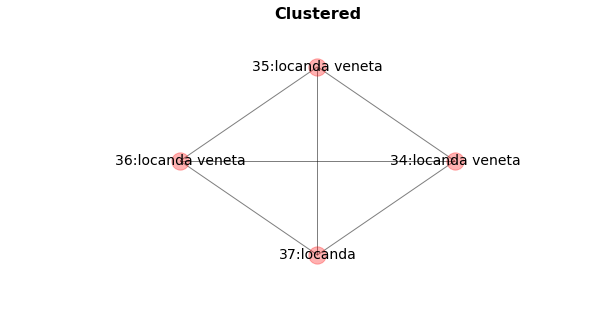

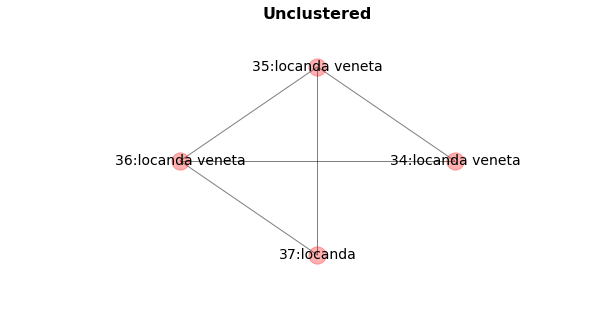

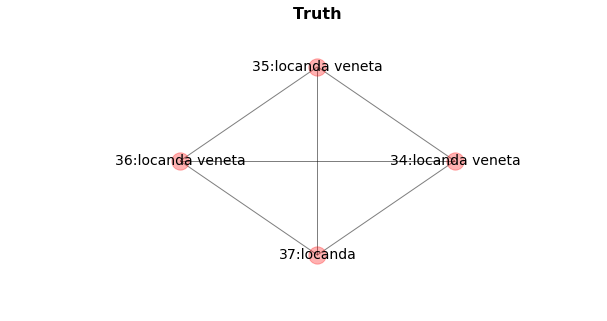

In [72]:
import matplotlib.pyplot as plt
import networkx as nx

def get_diff_pairs(diff_set_ids):
    diff_dedupe_clustered_pairs = [
        (x, y) for x, y in dedupe_found_pairs_set
        if x in diff_set_ids or y in diff_set_ids]
    diff_dedupe_unclustered_pairs = [
        (x, y) for x, y in dedupe_unclustered_found_pairs_set
        if x in diff_set_ids or y in diff_set_ids]
    diff_true_pairs = [
        (x, y) for x, y in golden_pairs_set
        if x in diff_set_ids or y in diff_set_ids]
    diff_all_ids = set(itertools.chain.from_iterable(
        diff_dedupe_clustered_pairs +
        diff_dedupe_unclustered_pairs +
        diff_true_pairs))
    return (
        diff_dedupe_clustered_pairs,
        diff_dedupe_unclustered_pairs,
        diff_true_pairs,
        diff_all_ids
    )

def draw_pairs_graph(edges, nodes, title):
    G = nx.Graph()
    for node in nodes:
        G.add_node(node,
                   name=str(node) + ':' + df.loc[node]['name'])
    G.add_edges_from(edges)

    plt.figure(figsize=(10, 5))
    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'name'), font_size=14)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.margins(0.5, 0.2)
    plt.axis('off')
    plt.title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.show()

good_diff_all_ids = {34, 35, 36, 37}
(
    diff_dedupe_clustered_pairs,
    diff_dedupe_unclustered_pairs,
    diff_true_pairs,
    diff_all_ids
) = get_diff_pairs(good_diff_all_ids)
display(df.loc[list(good_diff_all_ids)])
draw_pairs_graph(diff_dedupe_clustered_pairs, good_diff_all_ids, "Clustered")
draw_pairs_graph(diff_dedupe_unclustered_pairs, good_diff_all_ids, "Unclustered")
draw_pairs_graph(diff_true_pairs, good_diff_all_ids, "Truth")

And here's another case where the clustering process **dropped a true match**:

,name,addr,city,type,postal,lat,lng,addr_variations
8,bel air,701 stone canyon road,bel air,american,90077,34.086594,-118.446351,(701 stone canyon road)
6,hotel bel air,701 stone canyon rd.,bel air,californian,90077,34.086594,-118.446351,(701 stone canyon road)
7,bel air hotel,701 stone canyon rd.,bel air,californian,90077,34.086594,-118.446351,(701 stone canyon road)


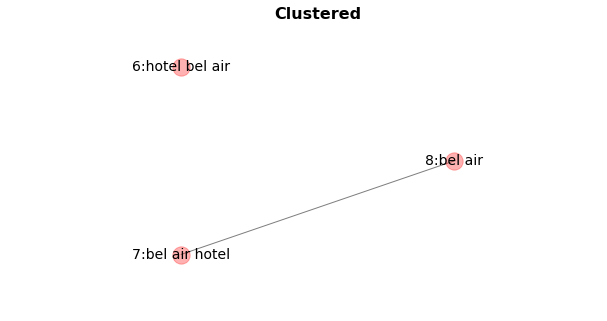

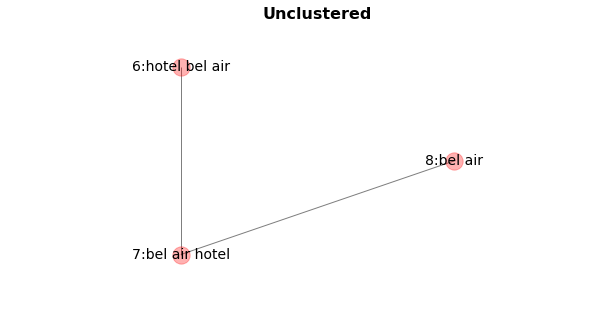

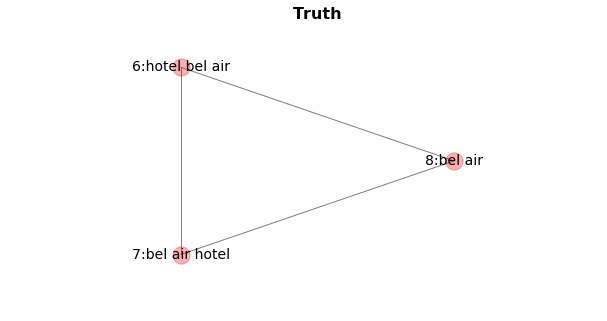

In [71]:
bad_diff_all_ids = {6, 7, 8}
(
    diff_dedupe_clustered_pairs,
    diff_dedupe_unclustered_pairs,
    diff_true_pairs,
    diff_all_ids
) = get_diff_pairs(bad_diff_all_ids)
display(df.loc[list(bad_diff_all_ids)])
draw_pairs_graph(diff_dedupe_clustered_pairs, bad_diff_all_ids, "Clustered")
draw_pairs_graph(diff_dedupe_unclustered_pairs, bad_diff_all_ids, "Unclustered")
draw_pairs_graph(diff_true_pairs, bad_diff_all_ids, "Truth")

Remember the `recall_weight` parameter of the `threshold` function? That's what it controls: how aggressive we want to be on finding or dropping matches while clustering. Check Dedupe docs for more details on how it [performs clustering](https://docs.dedupe.io/en/latest/Grouping-duplicates.html) and how it finds [a good threshold](https://docs.dedupe.io/en/latest/Choosing-a-good-threshold.html#).

## Ethics

(TODO)

## Next Steps

(TODO, put a small description links here)

- Data Fusion
- Incremental Record Linkage

## References

(TODO)